# 2. Data preprocessing
This notebook aims to use perform data preprocessing.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -qqq unidecode contractions pyspellchecker wordninja symspellpy emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.6 MB/s eta 0:00:00


In [3]:
# imports data analysis packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import wordninja

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

In [4]:
# Change to own directory
try:
    os.chdir("/content/drive/MyDrive/MyProject_SIDetection")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


## Load dataset

In [5]:
# Load dataset
data = pd.read_csv('Data_preprocessed.csv',index_col=0)
data.reset_index(drop=True, inplace=True)
data.head()

#116037datas

,class,text_clean_with_emojis,text_clean_without_emojis,lightclean_text_with_emojis,label
0,suicide,ex wife threatening suiciderecently left wife ...,ex wife threatening suiciderecently left wife ...,Ex Wife Threatening SuicideRecently I left my ...,1
1,non-suicide,weird get affected compliment coming someone k...,weird get affected compliment coming someone k...,Am I weird I don t get affected by compliments...,0
2,non-suicide,finally 2020 almost never hear 2020 bad year e...,finally 2020 almost never hear 2020 bad year e...,Finally 2020 is almost over So I can never hea...,0
3,suicide,need helpjust help im cry hard,need helpjust help im cry hard,i need helpjust help me im crying so hard,1
4,suicide,losthello name adam 16 struggling year afraid ...,losthello name adam 16 struggling year afraid ...,I m so lostHello my name is Adam 16 and I ve b...,1


In [7]:
#make those rows into string
data['text_clean_with_emojis'] = data['text_clean_with_emojis'].astype(str)
data['text_clean_without_emojis'] = data['text_clean_without_emojis'].astype(str)
data['lightclean_text_with_emojis'] = data['lightclean_text_with_emojis'].astype(str)

In [8]:
# Calculate average length of posts where 'is_suicide' is 1
data['text_length'] = data['text_clean_without_emojis'].apply(len)
ave_length_sui_post = data["text_length"][data['label'] == 1].mean()

# Calculate average word count of posts where 'is_suicide' is 1
data['word_count'] = data['text_clean_without_emojis'].apply(lambda x: len(x.split()))
ave_word_count_sui_post = data["word_count"][data['label'] == 1].mean()

print("Average length of a r/SuicideWatch post without emoji: {}".format(ave_length_sui_post))
print("Average word count of a r/SuicideWatch post without emoji: {}".format(ave_word_count_sui_post))

Average length of a r/SuicideWatch post without emoji: 585.5623551108698
Average word count of a r/SuicideWatch post without emoji: 91.3385127157717


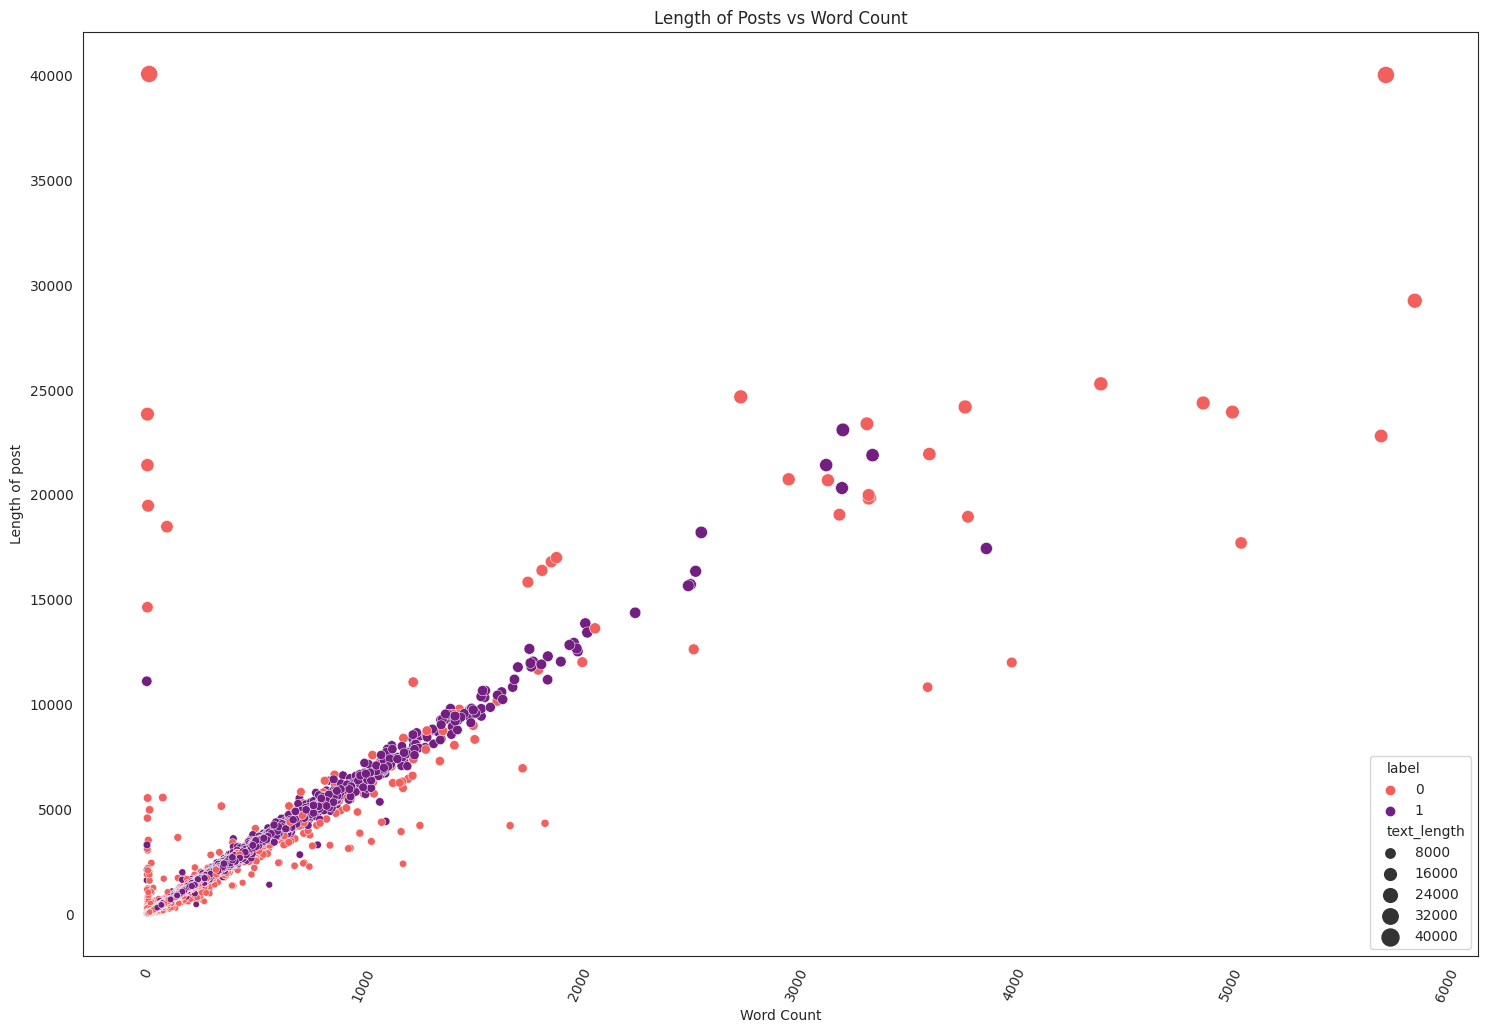

In [9]:
#Plot using 'word_count' as the x-axis
sns.set_style("white")
plt.figure(figsize=(18, 12))
sns.scatterplot(
    x='word_count',  # Use word count as the x-axis value
    y='text_length',  # Length of the post as y value
    hue='label',  # Coloring by the 'is_suicide' column
    palette="magma_r",
    size='text_length',  # Size of the points by the 'text_length' column
    sizes=(20, 150),  # Size range for the points
    data=data
)

plt.title("Length of Posts vs Word Count")
plt.xlabel("Word Count")  # Use word count as the x-axis
plt.ylabel("Length of post") # Use length as the y-axis
plt.xticks(rotation=65)
plt.show()


1. **Linear Relationship**:
<br>
    There's a clear linear relationship between the length of posts and word count for the majority of the data points. As one might expect, the more words in a post, the longer the post tends to be in terms of characters.
</br><br>
2. **Concentration of Points**:
<br>
    Most of the data points (posts) lie in the lower left portion of the plot, indicating that the majority of posts have a word count less than 1000 words and a length less than around 5000 characters.
</br><br>    
3. **"is_suicide" Classification**:
<br>
    The color differentiation allows to see whether there's a pattern in post lengths and word counts between posts that are classified as "suicide" (purple) and those that aren't (orange). From the plot, it seems both classes are spread throughout, but there seems to be a higher concentration of "suicide" posts in the denser region of the plot. This might indicate that "suicide" related posts tend to be of a certain length or word count, but it's not a definitive observation and would need further statistical analysis.
</br><br>      
4. **Size of Points (text_length)**:
<br>
    The varying sizes of the data points represent the character length of the posts. It's somewhat redundant since the y-axis already represents this information. It might be more informative to represent another variable through point size, such as the number of comments or engagement a post has, to get additional insights.
</br><br>   
5. **Outliers**:
<br>
    There are a few data points that lie far from the main cluster, especially on the right side. These represent posts that have an unusually high word count compared to the majority. It's worth investigating these posts separately to understand if they are anomalies, long stories, or some sort of data error.
</br>

In [10]:
pip install scattertext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=60d129a3c5c3ee7b4e8d829afb3c077df5ddcf9bebfe1a57cbefd643f6083b61
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext


In [ ]:
%matplotlib inline
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from IPython.display import IFrame, display, HTML
import spacy


display(HTML("<style>.container { width:98% !important; }</style>"))

In [ ]:
#CREATING A DATAFRAME FOR SCATTERTEXT

scatter_data = data.copy()
scatter_data.loc[:, "category"] = scatter_data["label"].map({0: "non-suicide", 1: "suicide"})
scatter_data.tail()

,class,text_clean_with_emojis,text_clean_without_emojis,lightclean_text_with_emojis,label,text_length,word_count,category
232069,non-suicide,like rock going get anything go,like rock going get anything go,If you don t like rock then your not going to ...,0,31,6,non-suicide
232070,non-suicide,tell many friend lonely everything deprived pr...,tell many friend lonely everything deprived pr...,You how you can tell i have so many friends an...,0,93,15,non-suicide
232071,non-suicide,pee probably taste like salty tea someone dran...,pee probably taste like salty tea someone dran...,pee probably tastes like salty tea can someone...,0,59,10,non-suicide
232072,suicide,usual stuff find herei posting sympathy pity k...,usual stuff find herei posting sympathy pity k...,The usual stuff you find hereI m not posting t...,1,884,141,suicide
232073,non-suicide,still beaten first bos hollow knight fought ti...,still beaten first bos hollow knight fought ti...,I still haven t beaten the first boss in Hollo...,0,92,15,non-suicide


In [ ]:
#PARSING TEXT FOR SCATTERTEXT
nlp = st.whitespace_nlp_with_sentences
scatter_data.groupby("category").apply(lambda x: x.text_clean_without_emojis.apply(lambda x: len(x.split())).sum())
scatter_data['parsed'] = scatter_data.text_clean_without_emojis.apply(nlp)
scatter_data.tail()

,class,text_clean_with_emojis,text_clean_without_emojis,lightclean_text_with_emojis,label,text_length,word_count,category,parsed
232069,non-suicide,like rock going get anything go,like rock going get anything go,If you don t like rock then your not going to ...,0,31,6,non-suicide,"(like, rock, going, get, anything, go)"
232070,non-suicide,tell many friend lonely everything deprived pr...,tell many friend lonely everything deprived pr...,You how you can tell i have so many friends an...,0,93,15,non-suicide,"(tell, many, friend, lonely, everything, depri..."
232071,non-suicide,pee probably taste like salty tea someone dran...,pee probably taste like salty tea someone dran...,pee probably tastes like salty tea can someone...,0,59,10,non-suicide,"(pee, probably, taste, like, salty, tea, someo..."
232072,suicide,usual stuff find herei posting sympathy pity k...,usual stuff find herei posting sympathy pity k...,The usual stuff you find hereI m not posting t...,1,884,141,suicide,"(usual, stuff, find, herei, posting, sympathy,..."
232073,non-suicide,still beaten first bos hollow knight fought ti...,still beaten first bos hollow knight fought ti...,I still haven t beaten the first boss in Hollo...,0,92,15,non-suicide,"(still, beaten, first, bos, hollow, knight, fo..."


In [ ]:
#DEFINING A CORPUS FOR SCATTERTEXT VISUALISATION
corpus = st.CorpusFromParsedDocuments(scatter_data, category_col="category", parsed_col="parsed").build()

In [ ]:
#CREATING A SCATTERTEXT PLOT
html = produce_scattertext_explorer(corpus,
                                    category='non-suicide',
                                    category_name='non-suicide',
                                    not_category_name='suicide',
                                    width_in_pixels=1000,
                                    jitter=0.1,
                                    minimum_term_frequency=5,
                                    transform=st.Scalers.percentile,
                                    metadata=scatter_data['category']
                                   )

In [ ]:
file_name = 'Reddit_ScattertextRankDataJitter.html'
with open(file_name, 'wb') as file:
    file.write(html.encode('utf-8'))

IFrame(src=file_name, width=1200, height=700)

1. **Text Parsing with Scattertext:**
<br>
The code uses scattertext, a tool for producing scatter plot visualizations of how different terms are used in different types of text data. While scattertext itself is a visualization tool, it requires the text data to be parsed. Parsing is an NLP task where raw text is converted into a structured format. The code uses st.whitespace_nlp_with_sentences to achieve this.
<br/><br>
2. **Text Categorization:**
<br>
The data is labeled with categories (Suicide and Non-Suicide). Categorization or classification is a central task in NLP, where text instances are assigned predefined labels.
<br/><br>
3. **Visualization with Scattertext:**
<br>
Once the data is parsed and categorized, the scattertext library is used to produce a scatter plot visualization. This visualization can help users understand how certain terms are more associated with one category than another.
<br/><br>
So, while the primary goal of the provided code is visualization, it utilizes NLP techniques to prepare and understand the text data for that visualization.

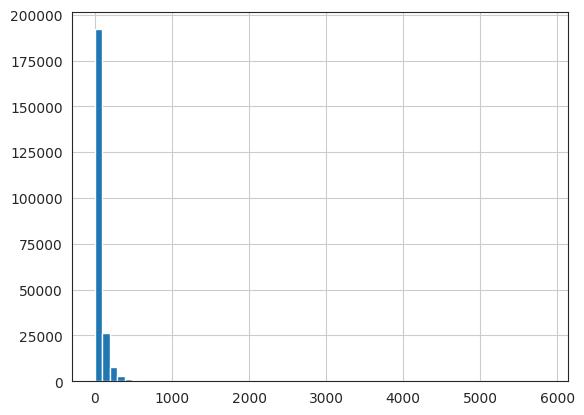

count    232074.000000
mean         60.440015
std         102.661193
min           0.000000
25%          13.000000
50%          28.000000
75%          70.000000
max        5850.000000
dtype: float64


In [24]:
# Get word count of posts (without emoji)
posts_len = [len(x.split()) for x in data['text_clean_without_emojis']]
pd.Series(posts_len).hist(bins=60)
plt.show()
print(pd.Series(posts_len).describe())

In [27]:
# Subset dataset to obtain rows with less than or equal to 70 words
cleaned_df = data[data['text_clean_without_emojis'].apply(lambda x: len(x.split())<=70)]
cleaned_df.reset_index(drop=True, inplace=True)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174388 entries, 0 to 174387
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   class                        174388 non-null  object
 1   text_clean_with_emojis       174388 non-null  object
 2   text_clean_without_emojis    174388 non-null  object
 3   lightclean_text_with_emojis  174388 non-null  object
 4   label                        174388 non-null  int64 
 5   text_length                  174388 non-null  int64 
 6   word_count                   174388 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 9.3+ MB


In [26]:
cleaned_df.head()

,class,text_clean_with_emojis,text_clean_without_emojis,lightclean_text_with_emojis,label,text_length,word_count
0,suicide,ex wife threatening suiciderecently left wife ...,ex wife threatening suiciderecently left wife ...,Ex Wife Threatening SuicideRecently I left my ...,1,396,61
1,non-suicide,weird get affected compliment coming someone k...,weird get affected compliment coming someone k...,Am I weird I don t get affected by compliments...,0,88,13
2,non-suicide,finally 2020 almost never hear 2020 bad year e...,finally 2020 almost never hear 2020 bad year e...,Finally 2020 is almost over So I can never hea...,0,76,13
3,suicide,need helpjust help im cry hard,need helpjust help im cry hard,i need helpjust help me im crying so hard,1,30,6
4,suicide,end tonight anymore quit,end tonight anymore quit,It ends tonight I can t do it anymore I quit,1,24,4


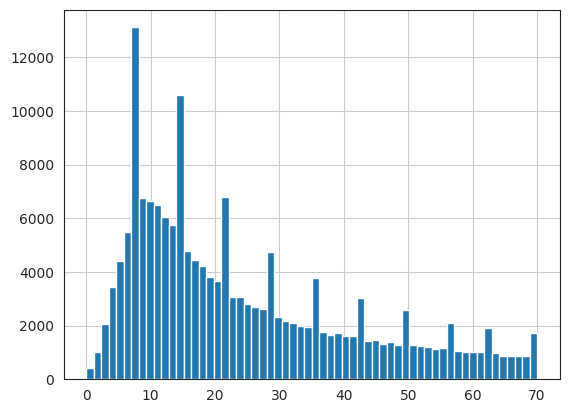

count    174388.000000
mean         24.471420
std          17.456266
min           0.000000
25%          11.000000
50%          19.000000
75%          35.000000
max          70.000000
dtype: float64


In [15]:
# show word count of posts of the subset
posts_len2 = [len(x.split()) for x in cleaned_df['text_clean_without_emojis']]
pd.Series(posts_len2).hist(bins=60)
plt.show()
print(pd.Series(posts_len2).describe())

### Separate the data into different dataset in csv form for future used.

In [28]:
#separate data for modelling_data_heavyclean (without emoji)

data_heavyclean = cleaned_df[['text_clean_without_emojis','label']]
data_heavyclean.rename(columns={"text_clean_without_emojis": "text"},inplace = True)
data_heavyclean['text'] = data_heavyclean['text'].str.replace(r'\s\s+', ' ', regex=True)
data_heavyclean = data_heavyclean[data_heavyclean['text'] != 'nan']
data_heavyclean.info()

<ipython-input-28-c3cbae66d04c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_heavyclean.rename(columns={"text_clean_without_emojis": "text"},inplace = True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 174295 entries, 0 to 174387
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    174295 non-null  object
 1   label   174295 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ MB


<ipython-input-28-c3cbae66d04c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_heavyclean['text'] = data_heavyclean['text'].str.replace(r'\s\s+', ' ', regex=True)


0    107027
1     67268
Name: label, dtype: int64
0    0.614057
1    0.385943
Name: label, dtype: float64


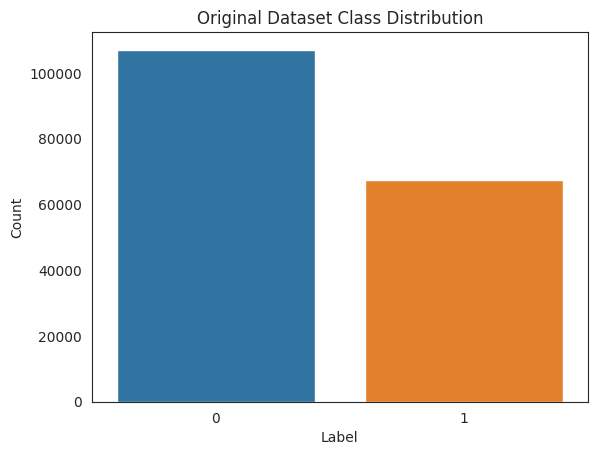

In [29]:
# Check class distribution
print(data_heavyclean['label'].value_counts())
print(data_heavyclean['label'].value_counts(normalize=True))

sns.countplot(x=data_heavyclean['label'])
plt.title('Original Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [30]:
#separate data for modelling_data_ with emoji

data_heavyclean_emoji = cleaned_df[['text_clean_with_emojis','label']]
data_heavyclean_emoji.rename(columns={"text_clean_with_emojis": "text"},inplace = True)
data_heavyclean_emoji['text'] = data_heavyclean_emoji['text'].str.replace(r'\s\s+', ' ', regex=True)
data_heavyclean_emoji = data_heavyclean_emoji[data_heavyclean_emoji['text'] != 'nan']
data_heavyclean_emoji.info()

<ipython-input-30-28e19c823169>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_heavyclean_emoji.rename(columns={"text_clean_with_emojis": "text"},inplace = True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 174295 entries, 0 to 174387
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    174295 non-null  object
 1   label   174295 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ MB


<ipython-input-30-28e19c823169>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_heavyclean_emoji['text'] = data_heavyclean_emoji['text'].str.replace(r'\s\s+', ' ', regex=True)


In [33]:
#separate data for transformers

data_lightclean = data[['lightclean_text_with_emojis','label']]
data_lightclean.rename(columns={"lightclean_text_with_emojis": "text"},inplace = True)
data_lightclean['text'] = data_lightclean['text'].str.replace(r'\s\s+', ' ', regex=True)
data_lightclean = data_lightclean[data_lightclean['text'] != 'nan']
data_lightclean.info()

<ipython-input-33-60b21f327c35>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lightclean.rename(columns={"lightclean_text_with_emojis": "text"},inplace = True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 232015 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232015 non-null  object
 1   label   232015 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ MB


<ipython-input-33-60b21f327c35>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lightclean['text'] = data_lightclean['text'].str.replace(r'\s\s+', ' ', regex=True)


1    116031
0    115984
Name: label, dtype: int64
1    0.500101
0    0.499899
Name: label, dtype: float64


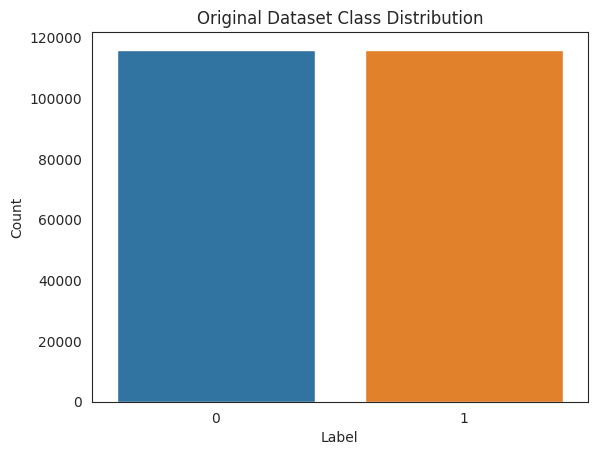

In [35]:
# Check class distribution
print(data_lightclean['label'].value_counts())
print(data_lightclean['label'].value_counts(normalize=True))

sns.countplot(x=data_lightclean['label'])
plt.title('Original Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [34]:
#save data for modelling
data_heavyclean.to_csv('data_heavyclean.csv', index = False)
data_heavyclean_emoji.to_csv('data_heavyclean_emoji.csv', index = False)
data_lightclean.to_csv('data_lightclean.csv', index = False)